Change learner to attempt to overfit AdaBoost.

In [9]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Pipeline
from tree import TreeModel

# ===== import data; tr,ts ======
X_tr = pd.read_csv('split-data/processed/X_tr.csv')
X_ts = pd.read_csv('split-data/processed/X_ts.csv')
y_tr = pd.read_csv('split-data/processed/y_tr.csv')
y_ts = pd.read_csv('split-data/processed/y_ts.csv')

In [2]:
# ===== AdaBoost =====
start = time.time()

ab_params = {
    'X_tr': X_tr.to_numpy(),
    'X_ts': X_ts.to_numpy(),
    'y_tr': y_tr.values.ravel(),
    'y_ts': y_ts.values.ravel(),
    'model': AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME'), # Avoid warning messages instead of SAMME.R - default
    'name': 'AdaBoost'
}

ab_pipeline = TreeModel(**ab_params)

ab_fit_params = {
    'param_grid': {
        'n_estimators': [50, 100, 500, 1000],
        'learning_rate': [0.1, 0.5, 1.0, 2.0],
        'estimator__max_depth': [1, 3, 5],
    },
    'balance_classes': False,
    'k_folds': 2,
    'scoring': 'accuracy'
}

ab_pipeline.fit_predict(**ab_fit_params)

end = time.time()
elapsed = end - start
print(f"Elapsed time: {elapsed:.2f} seconds")

Elapsed time: 483.44 seconds


In [6]:
print("Best Hyperparameters:", ab_pipeline.grid.best_params_)
ab_pipeline.tr_ts_scoring

Best Hyperparameters: {'estimator__max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 1000}
AdaBoostClassifier(algorithm='SAMME', estimator=DecisionTreeClassifier())
Grid - Hyperparameters: ['n_estimators', 'learning_rate', 'estimator__max_depth']
Train Accuracy: 87.076%
CV Validation Accuracy: 86.440%
Test Accuracy: 86.720%


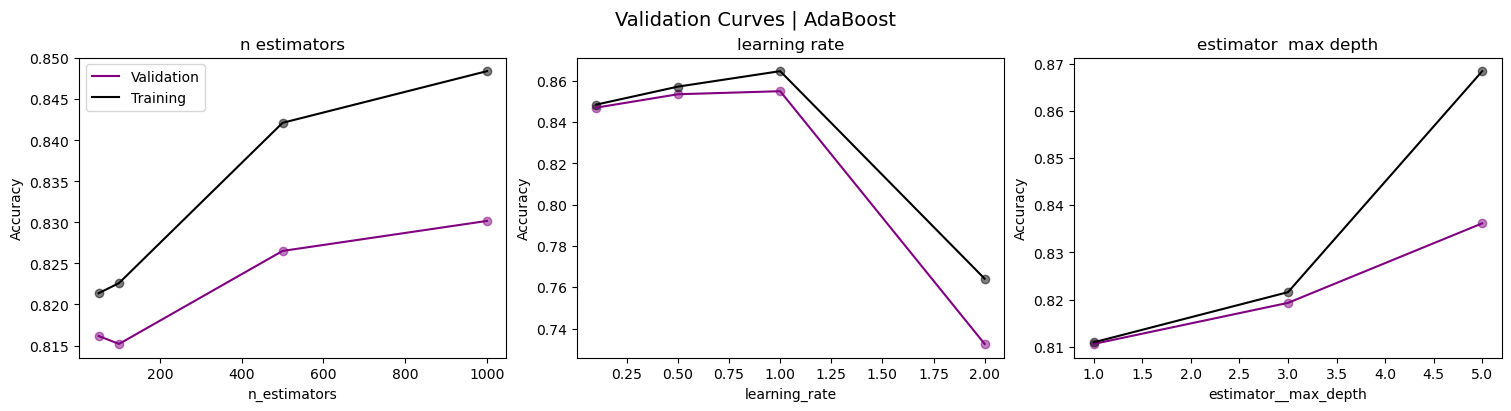

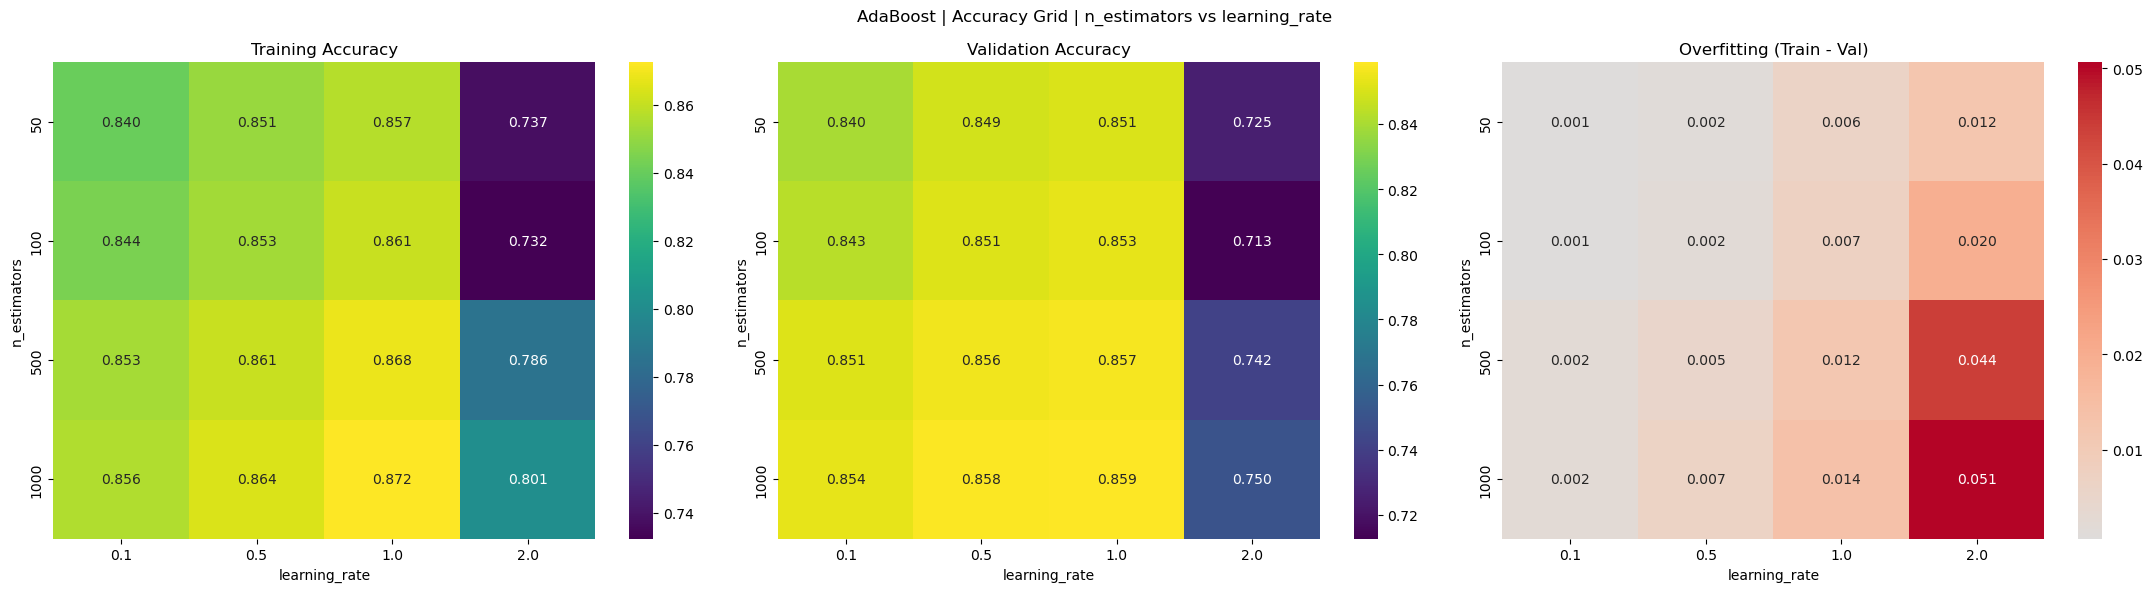

In [7]:
# ===== AdaBoost Scoring & Visualization ======
os.makedirs('media/04_adaboost', exist_ok=True)

plot_vhgr_params = {
    'param_list': ab_pipeline.hyper_grid,
    'figsize': (5, 4),
    'save_path': 'media/04_adaboost/balanced_validation_curvesV2.png'
}
ab_pipeline.plot_validation_hyperparam_grid_row(**plot_vhgr_params)

ab_pipeline.viz_heatmap_cv(
    top_two_params_for_overfitting=['n_estimators', 'learning_rate'],
    dir_save_path='media/04_adaboost'
)

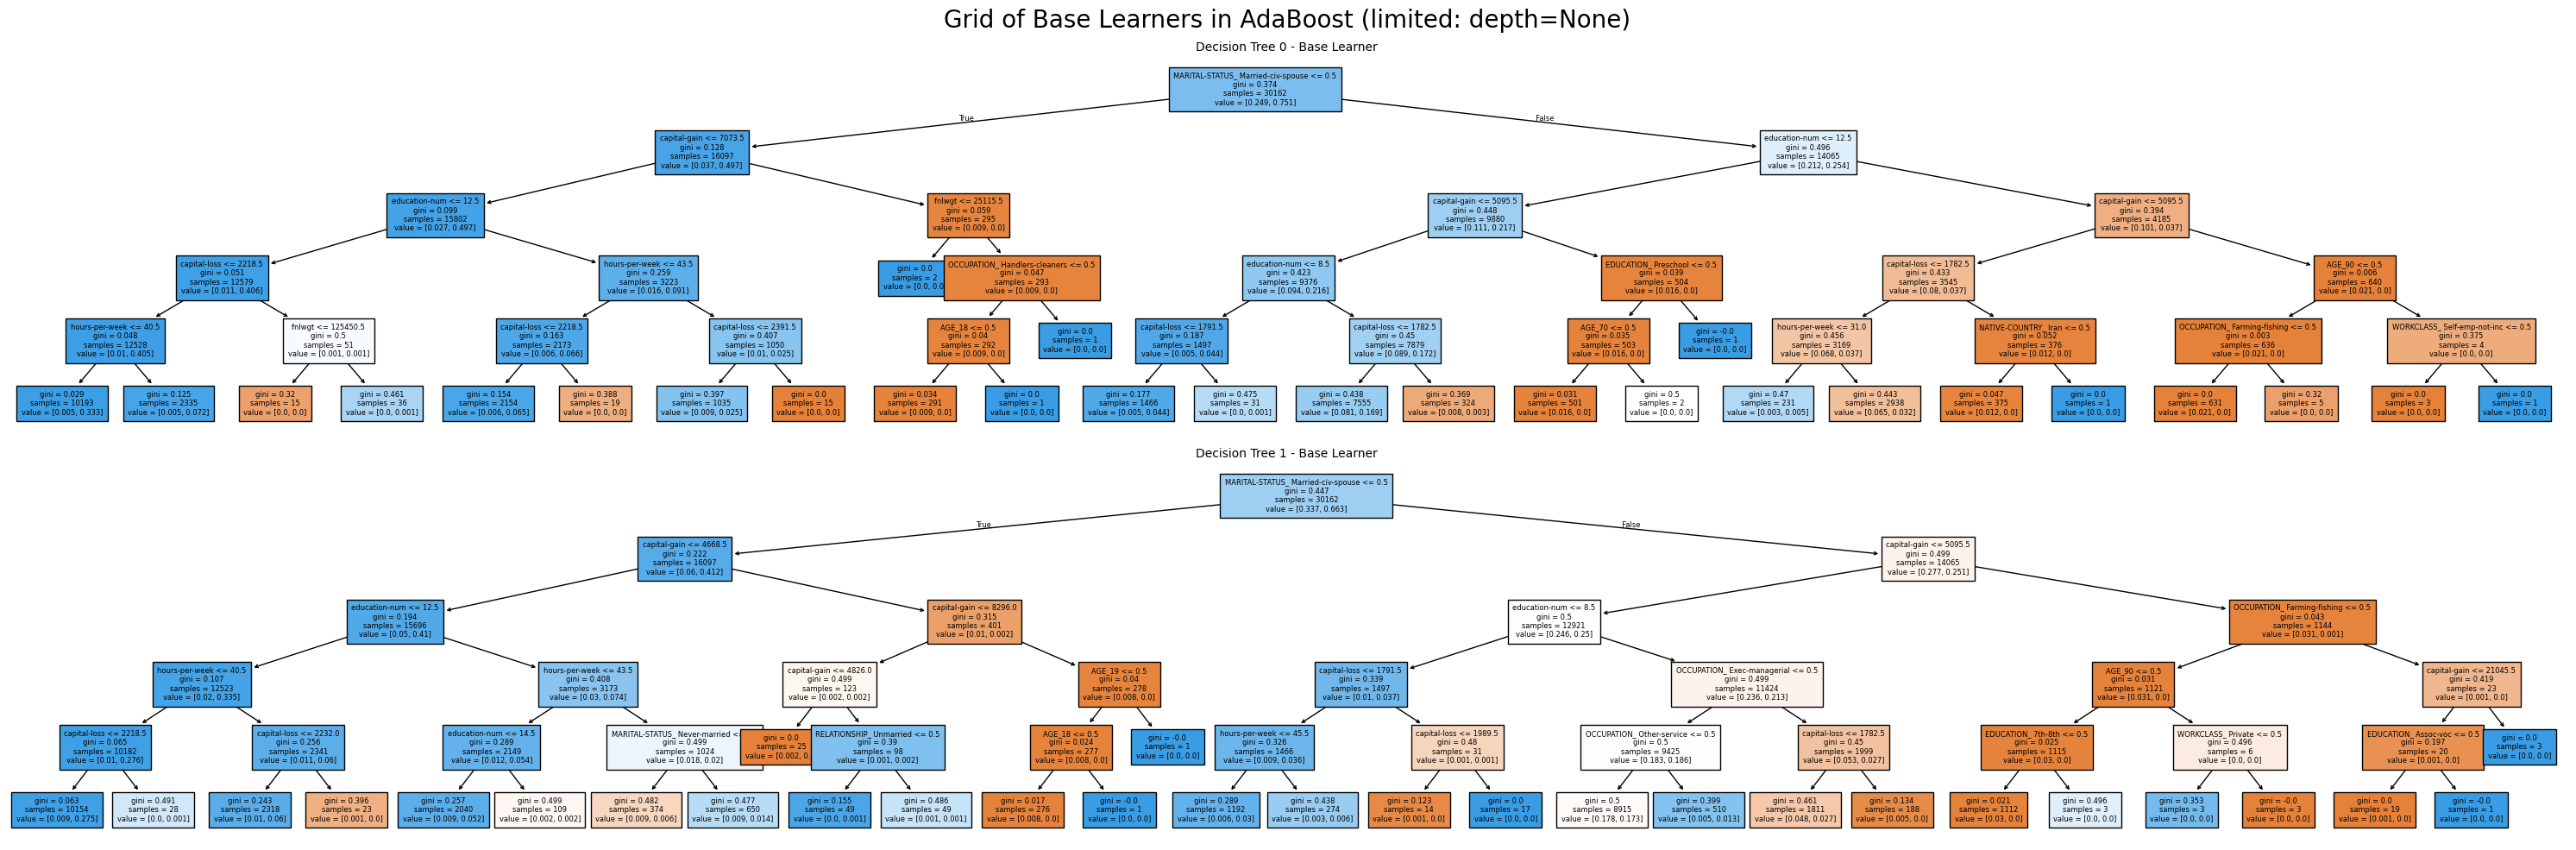

In [ ]:
ab_model = ab_pipeline.grid.best_estimator_
depth = None

cols = 1
fig, axes = plt.subplots(2, cols, figsize=(30, 10))
axes = axes.flatten() 

for i in range(2*cols):
    plot_tree(
        ab_model.estimators_[i],
        filled=True,
        max_depth=depth,
        feature_names=X_tr.columns,
        fontsize=6,
        ax=axes[i] 
    )
    axes[i].set_title(f'Decision Tree {i} - Base Learner ', fontsize=10)

plt.suptitle(f'Grid of Base Learners in AdaBoost (limited: depth={depth})', fontsize=20)
plt.tight_layout()
plt.savefig('media/04_adaboost/base_learner_viz.png', bbox_inches='tight')
plt.show()

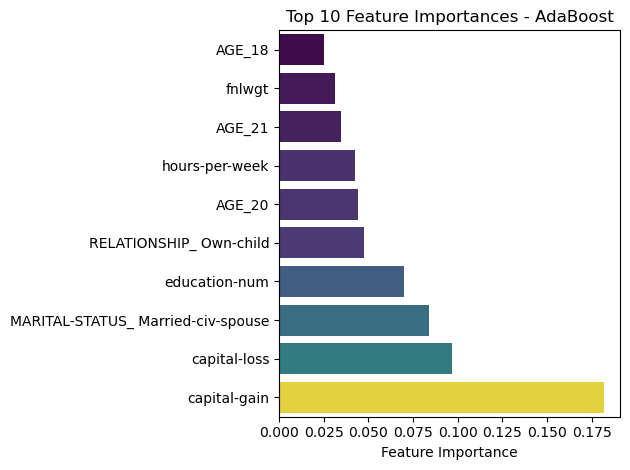

In [21]:
# ===== AdaBoost Feature Importances ======
k = 10
best_ab = ab_pipeline.grid.best_estimator_

ab_importances = pd.Series(best_ab.feature_importances_, index=X_tr.columns)
top_features = ab_importances.sort_values(ascending=False).head(k)

sns.barplot(
    x=top_features.sort_values().values,
    y=top_features.sort_values().index,
    hue=top_features.sort_values().values,
    dodge=False,
    palette='viridis',
    legend=False
)

plt.title(f"Top {k} Feature Importances - AdaBoost")
plt.xlabel("Feature Importance")
plt.ylabel('')
plt.tight_layout()
plt.savefig('media/04_adaboost/significant_features_viz.png')
plt.show()